In [ ]:
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3

import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
from matplotlib import colors
from cycler import cycler

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [11]:
"""Define optics"""

IMAGE_SIZE = 256
NUMBER_OF_PARTICLES = 50 #in 1400x1200 picture, said to be up to 60.


NUMBER_OF_PARTICLES = round(256*256/(1400*1200)*NUMBER_OF_PARTICLES)
Z_RANGE = 300
sigma = 10

particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE) * np.random.rand(2),
    z=lambda: -(300+Z_RANGE//2)//2 + np.random.random()*(300+Z_RANGE//2),
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

particle_middle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE//2, IMAGE_SIZE//2),
    z=lambda: -Z_RANGE//2 + np.random.random() * Z_RANGE,
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner
CROP = dt.Lambda(crop, pupil_radius=IMAGE_SIZE//6)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=635e-9,
    aperature_angle=53.7 * 2 * np.pi / 360,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil=HC+VC + CROP,
)

real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda level: np.random.rand() * 0.05,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda real_sigma: real_sigma * 0.05j,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 5e-5,
)



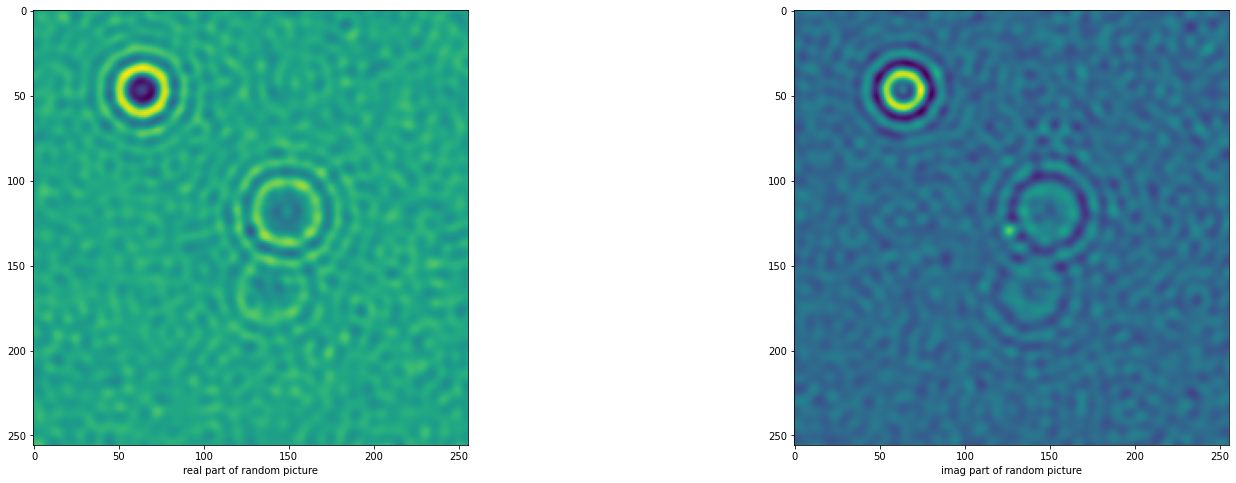

In [12]:
"""Plotting one random image and creating the dataset"""
def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

complex_to_float = dt.Lambda(func)

def particles(particle):
    return particle ** (np.random.randint(NUMBER_OF_PARTICLES+1)+1)
                                                 
#dt.FlipUD(dt.FlipLR(dt.FlipDiagonal(XXXXXXX)))

dataset = optics(particle_middle + particles(particle) + noise + gradient) + complex_to_float
dataset = dt.FlipLR(dt.FlipUD(dt.FlipDiagonal(dataset)))
test_image = dataset.update().resolve()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
ax1.imshow(test_image[:,:,0])
ax1.set_xlabel("real part of random picture")
ax2.imshow(test_image[:,:,1])
ax2.set_xlabel("imag part of random picture")
plt.show()

In [13]:
"""get_label returns the z position of the middle particle, but normalized to [0,1]"""
def get_label(image):
    return np.array([(image.get_property("z")+Z_RANGE/2)/Z_RANGE])

In [ ]:
from keras import layers, models, datasets
kernelsizes = [3,5,7, 15]
models_to_train = []
for _ in range(3):
    for kernelsize in kernelsizes:
        model = models.Sequential()
        model.add(layers.Conv2D(16, kernelsize, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2)))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(32, kernelsize, activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(64, kernelsize, activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(128, kernelsize, activation='relu'))

        model.add(layers.Flatten())

        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='huber')


        model.totalhistory = {"val_loss":[], "loss":[]}
        model.specs={"kernelsize":kernelsize}
        models_to_train.append(model)
        model.summary()

In [ ]:
from keras import layers, models, datasets
"Skapar 3 olika modeller i 3 kopior"
models_to_train = []
for _ in range(3):
    #model 1
    model1 = models.Sequential()
    model1.add(layers.Conv2D(16, 3, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2)))
    model1.add(layers.MaxPooling2D(pool_size=(2,2)))
    model1.add(layers.Conv2D(32, 3, activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2,2)))
    model1.add(layers.Conv2D(64, 3, activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2,2)))

    model1.add(layers.Flatten())

    model1.add(layers.Dense(64, activation='relu'))
    model1.add(layers.Dense(32, activation='relu'))
    model1.add(layers.Dense(1, activation='sigmoid'))
    model1.compile(optimizer='adam', loss='huber')

    model1.totalhistory = {"val_loss":[], "loss":[]}
    model1.specs="3 st kernel_size 3x3, med maxpooling 2x2"
    model1.summary()
    models_to_train.append(model1)

    #model 2
    model2 = models.Sequential()
    model2.add(layers.Conv2D(16, 3, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2)))
    model2.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))
    model2.add(layers.Conv2D(32, 3, activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))
    model2.add(layers.Conv2D(64, 3, activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))

    model2.add(layers.Flatten())

    model2.add(layers.Dense(64, activation='relu'))
    model2.add(layers.Dense(32, activation='relu'))
    model2.add(layers.Dense(1, activation='sigmoid'))
    model2.compile(optimizer='adam', loss='huber')

    model2.totalhistory = {"val_loss":[], "loss":[]}
    model2.specs="3 st kernel_size 3x3, med maxpooling 4x4"
    model2.summary()
    models_to_train.append(model2)

    #model 3
    model3 = models.Sequential()
    model3.add(layers.Conv2D(16, 16, activation='relu', strides=(3,3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2)))
    model3.add(layers.Conv2D(32, 32, activation='relu', strides=(2,2)))
    model3.add(layers.Conv2D(32, 16, activation='relu'))

    model3.add(layers.Flatten())

    model3.add(layers.Dense(64, activation='relu'))
    model3.add(layers.Dense(32, activation='relu'))
    model3.add(layers.Dense(1, activation='sigmoid'))
    model3.compile(optimizer='adam', loss='huber')

    model3.totalhistory = {"val_loss":[], "loss":[]}
    model3.specs="3 st kernel_size 16, 32, 16 och stride 3, 2 ingen maxpooling"
    model3.summary()
    models_to_train.append(model3)

In [16]:
"""Helper functions to visualize progress during training."""

def save_progress(h, validation_set, validation_labels, model, plot=True):
    model.totalhistory["val_loss"].extend(h.history["val_loss"])
    model.totalhistory["loss"].extend(h.history["loss"])
                
    if plot:
        validation_predictions = model.predict(np.array(validation_set))
        std = np.std(validation_predictions-np.array(validation_labels))
        mean = np.mean(validation_predictions-np.array(validation_labels))
        model.stats = {"sigma":np.round(std*Z_RANGE, decimals=3), "mu":np.round(mean*Z_RANGE, decimals=3)}
        print(model.stats)

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8))

        ax1.plot(model.totalhistory["val_loss"], 'g', label="validation loss")
        ax1.plot(model.totalhistory["loss"], 'b', label="training loss")
        ax1.set_xlabel("Epoch")
        ax1.set_yscale('log')
        ax1.legend()

        ax2.scatter(np.array(validation_predictions)*Z_RANGE-Z_RANGE/2, np.array(validation_labels)*Z_RANGE-Z_RANGE/2)
        ax2.plot(np.linspace(-Z_RANGE/2,Z_RANGE/2),np.linspace(-Z_RANGE/2,Z_RANGE/2),'k')
        ax2.set_xlabel("predicted z")
        ax2.set_ylabel("actual z")

        ax3.hist(Z_RANGE*np.array((validation_predictions-np.array(validation_labels))), bins=list(np.linspace(-Z_RANGE/2,Z_RANGE/2,10*Z_RANGE)))
        ax3.set_xlabel("Pixlar från faktiskt värde")

        ax4.imshow(validation_set[np.random.randint(validation_set_size)][:,:,0])

        plt.show()

def plot_together(models):
    cc = (cycler(color=list('bgrcmykbgrcmykbgrcmykbgrcmyk')) +
      cycler(linestyle=['-','-','-','-','-','-','-','--','--','--','--','--','--','--','-.','-.','-.','-.','-.','-.','-.',':',':',':',':',':',':',':']))
    
    fig, ax = plt.subplots(1,1,figsize=(15,15))
    ax.set_prop_cycle(cc)
    for i, model in enumerate(models):
        ax.plot(moving_average(model.totalhistory["val_loss"], min(100, len(model.totalhistory["val_loss"])//4)), label=f"Model {i}, {model.specs}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Validation loss")
        ax.set_yscale("log")
        ax.legend()

    ax.grid(True)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Generating 519 / 512 samples before starting training
3 st kernel_size 3x3, med maxpooling 2x2
{'sigma': 41.544, 'mu': -1.541}


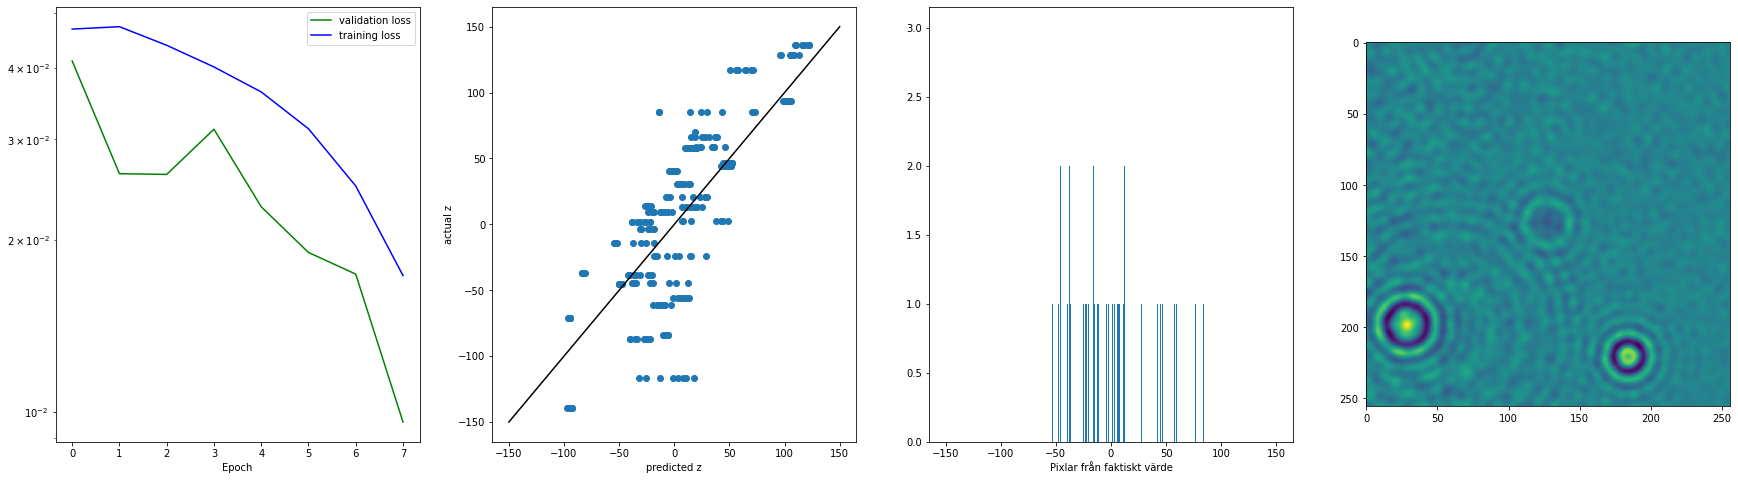

3 st kernel_size 3x3, med maxpooling 4x4
{'sigma': 39.515, 'mu': 15.441}


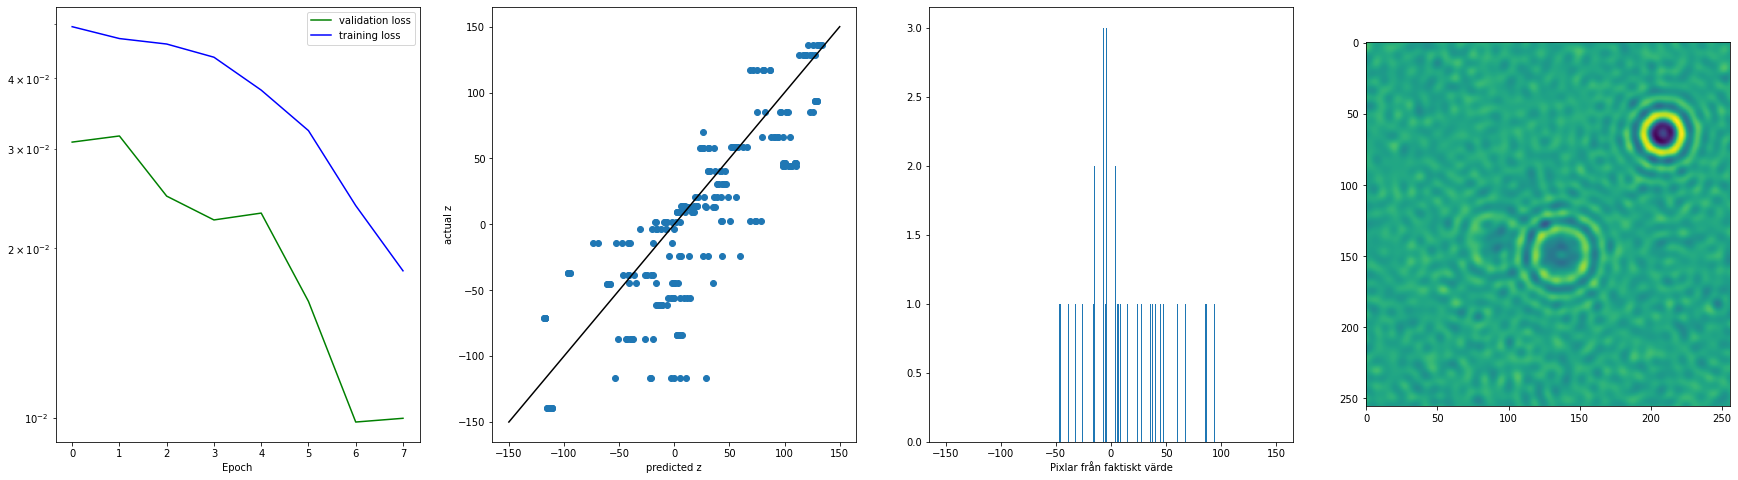

3 st kernel_size 16, 32, 16 och stride 3, 2 ingen maxpooling
{'sigma': 44.176, 'mu': 2.563}


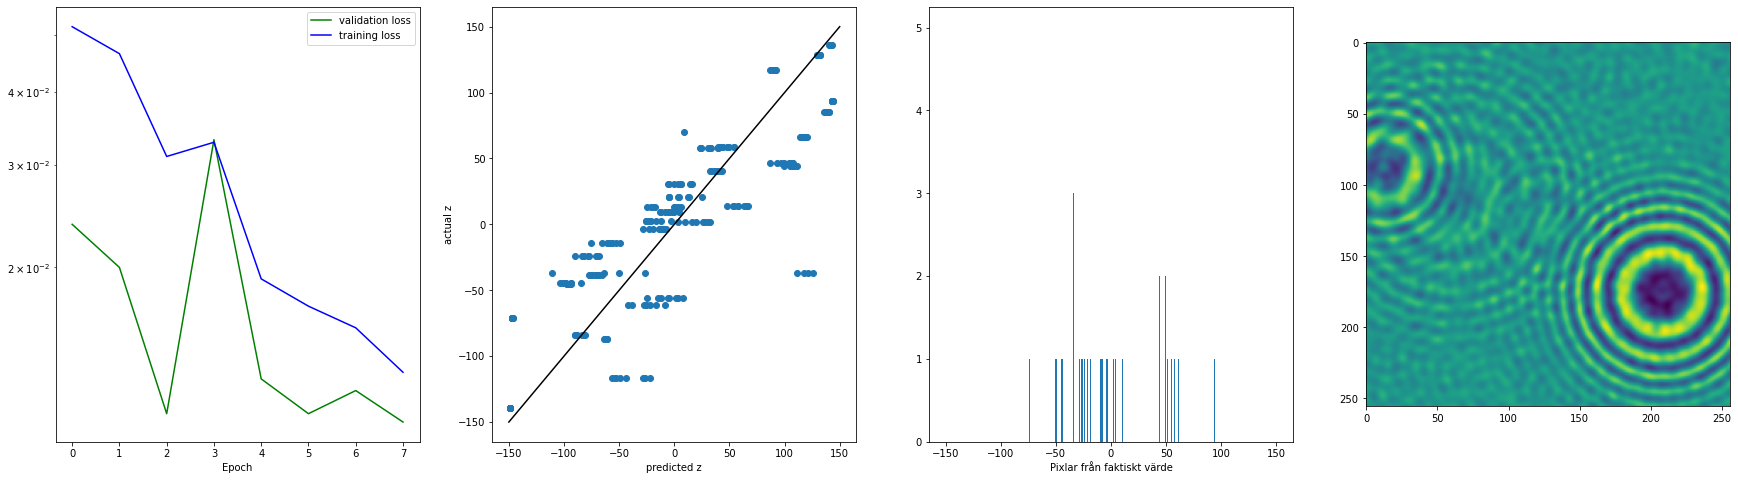

3 st kernel_size 3x3, med maxpooling 2x2
{'sigma': 32.332, 'mu': 5.784}


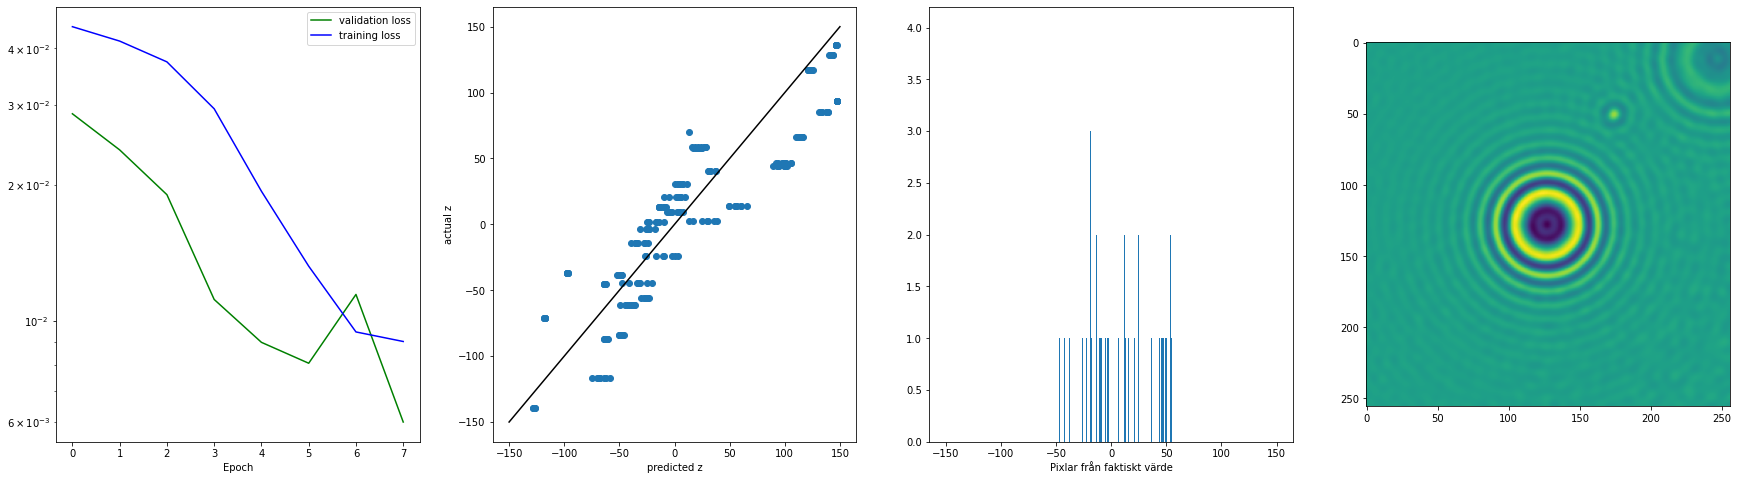

3 st kernel_size 3x3, med maxpooling 4x4
{'sigma': 36.306, 'mu': -1.246}


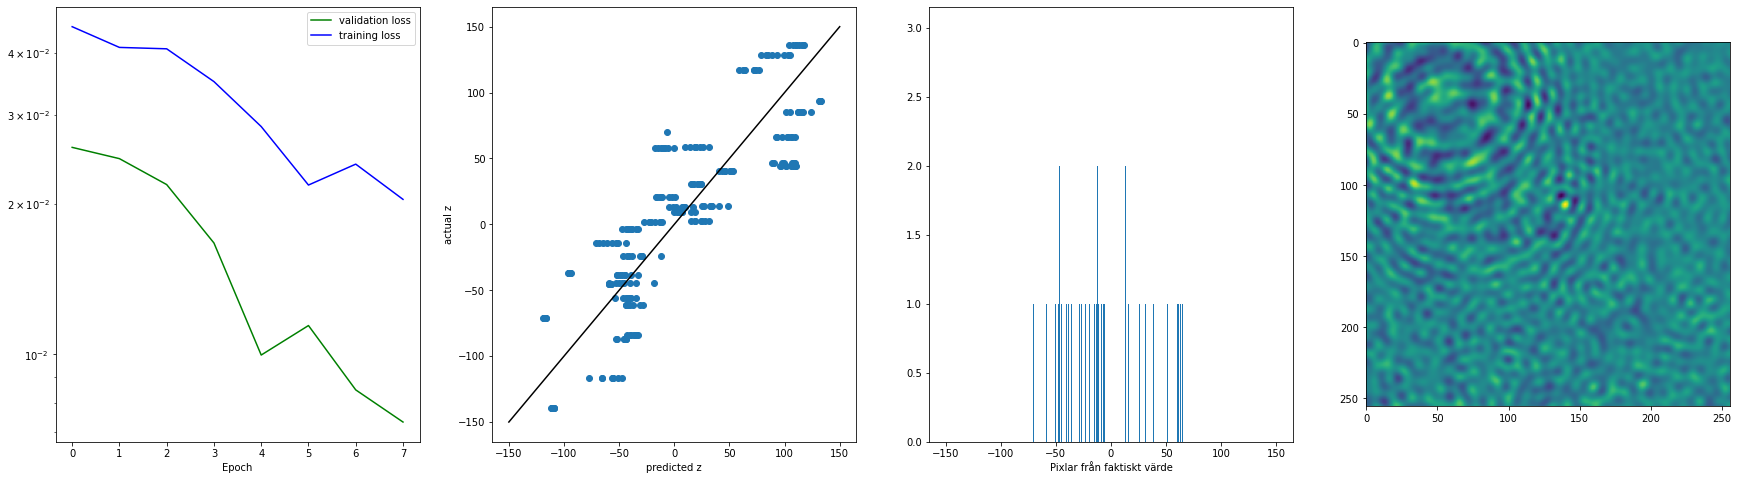

3 st kernel_size 16, 32, 16 och stride 3, 2 ingen maxpooling
{'sigma': 29.98, 'mu': 10.356}


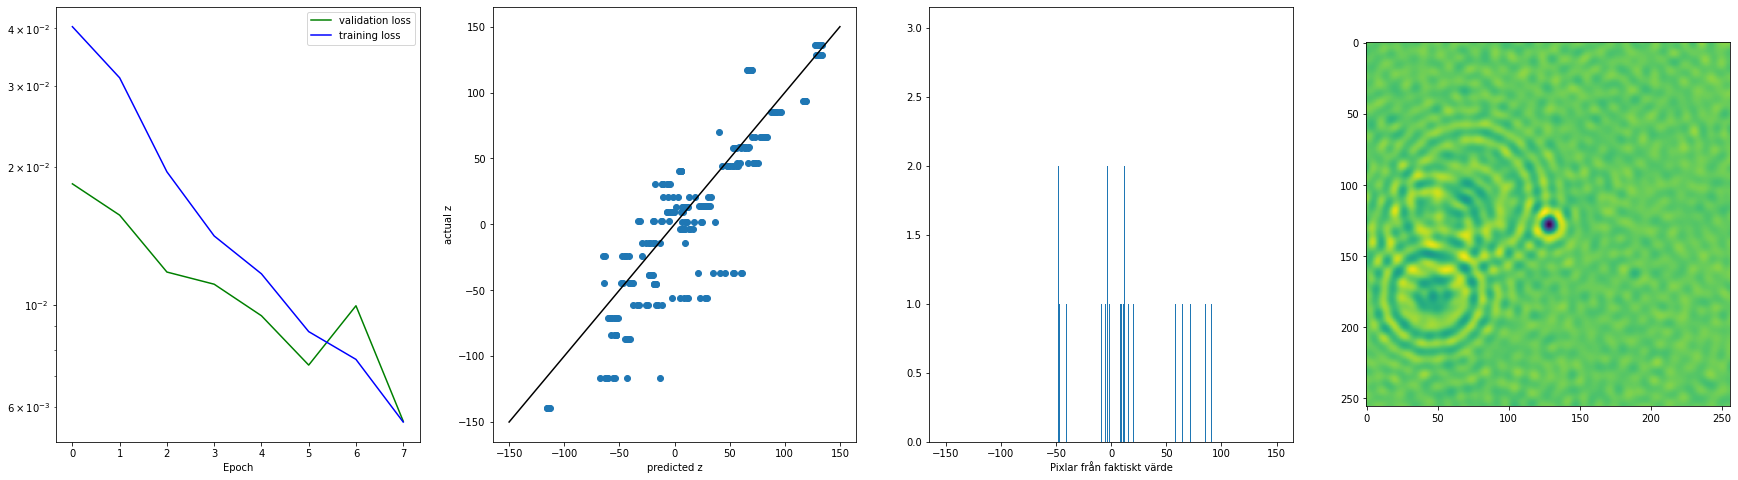

3 st kernel_size 3x3, med maxpooling 2x2
{'sigma': 35.693, 'mu': 10.649}


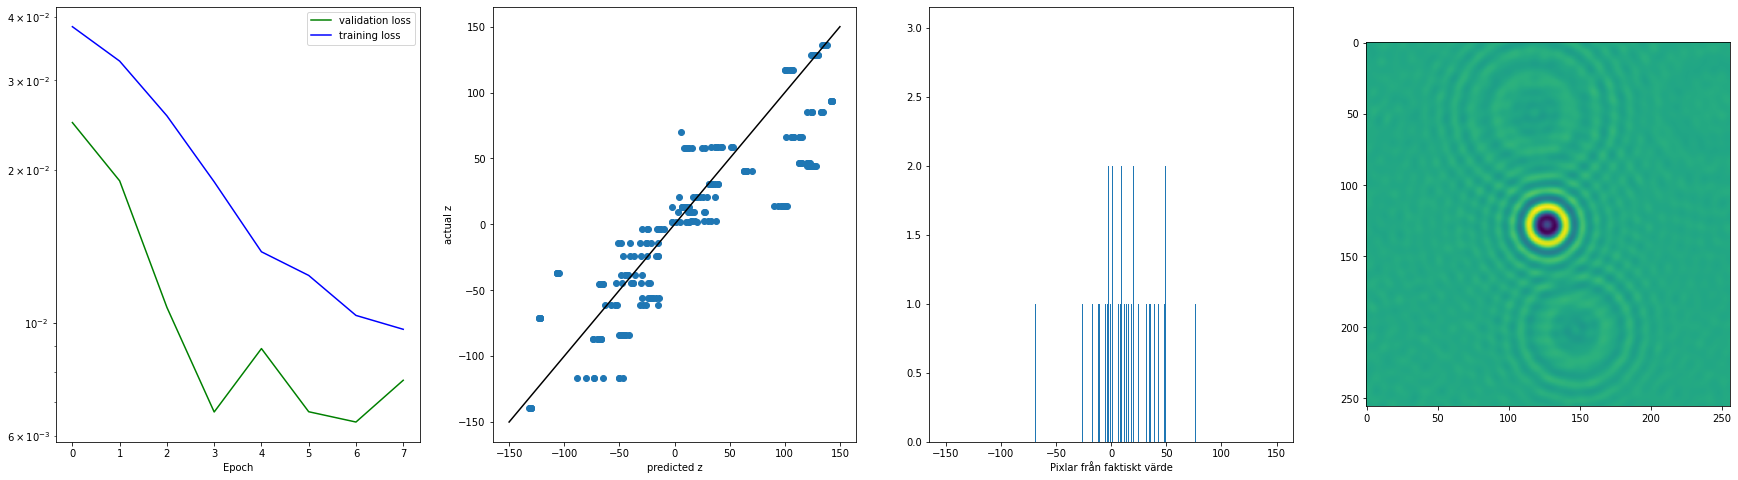

3 st kernel_size 3x3, med maxpooling 4x4
{'sigma': 40.162, 'mu': -3.886}


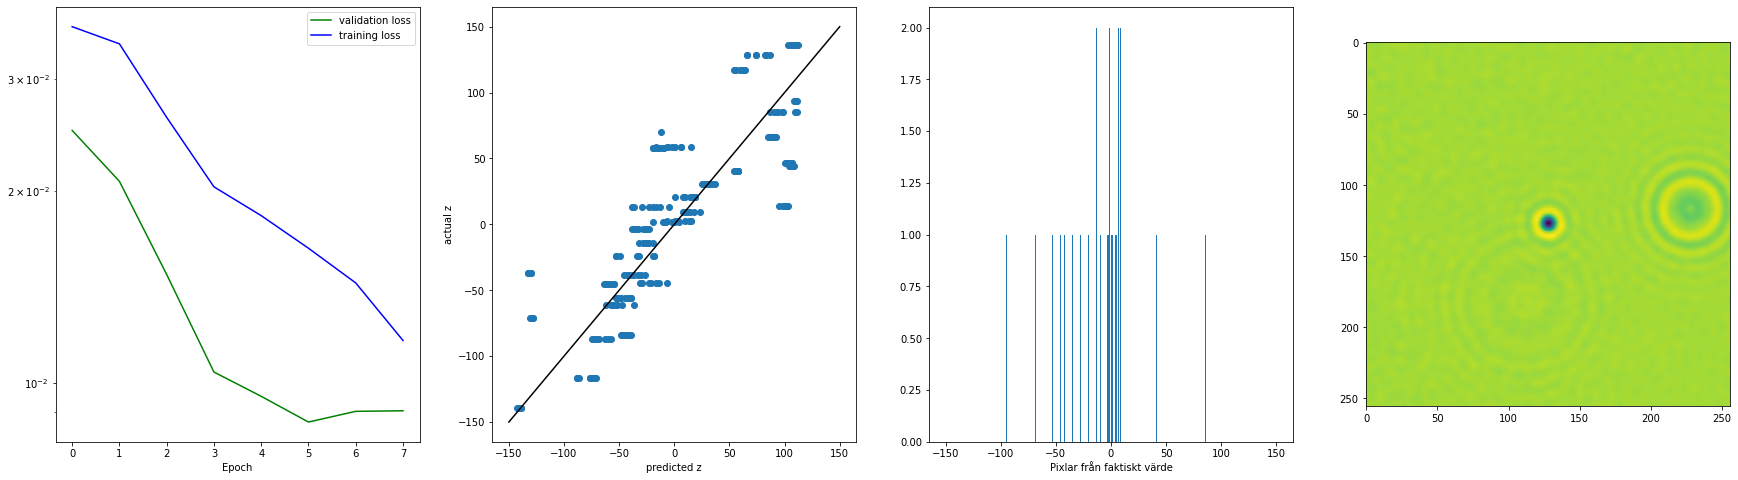

3 st kernel_size 16, 32, 16 och stride 3, 2 ingen maxpooling
{'sigma': 36.122, 'mu': 12.058}


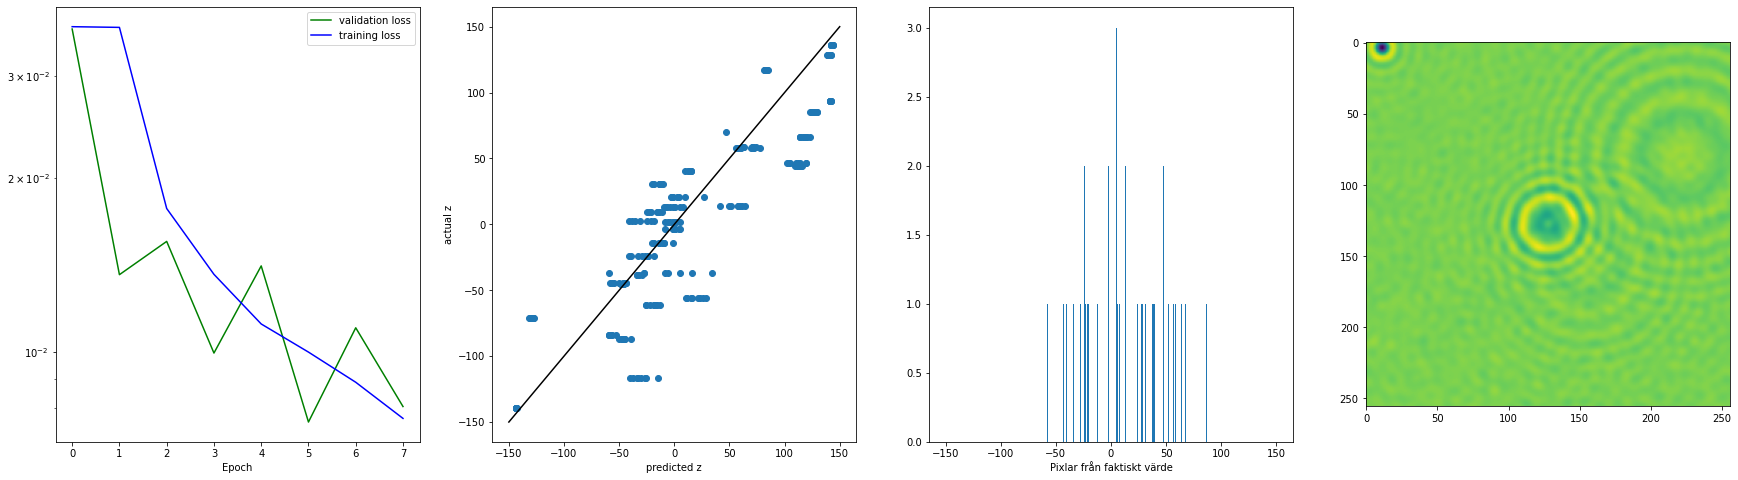

welcome!


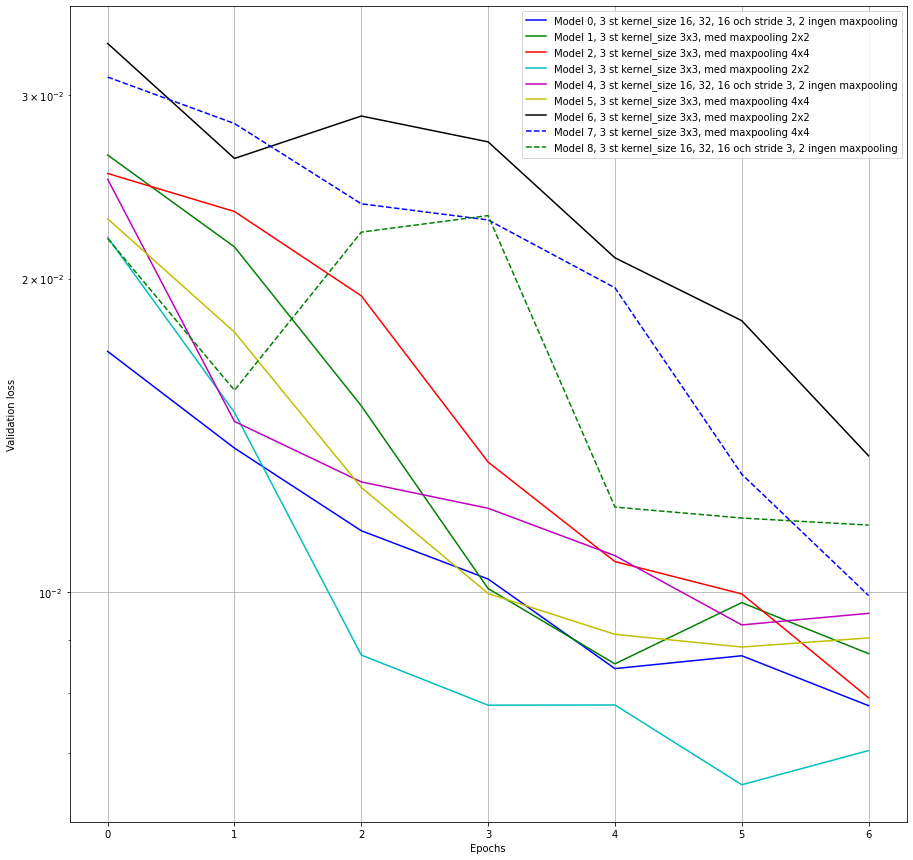

Generating 768 / 512 samples before starting training
3 st kernel_size 16, 32, 16 och stride 3, 2 ingen maxpooling
{'sigma': 25.027, 'mu': 4.099}


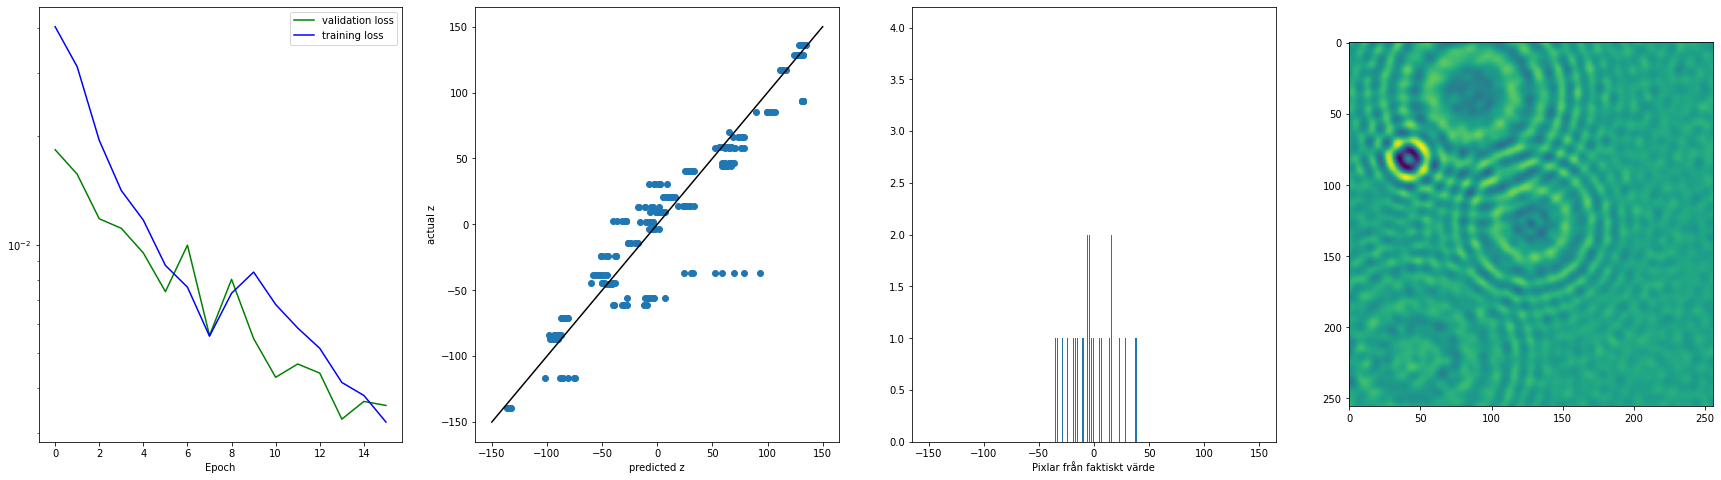

3 st kernel_size 3x3, med maxpooling 2x2
{'sigma': 32.889, 'mu': 1.203}


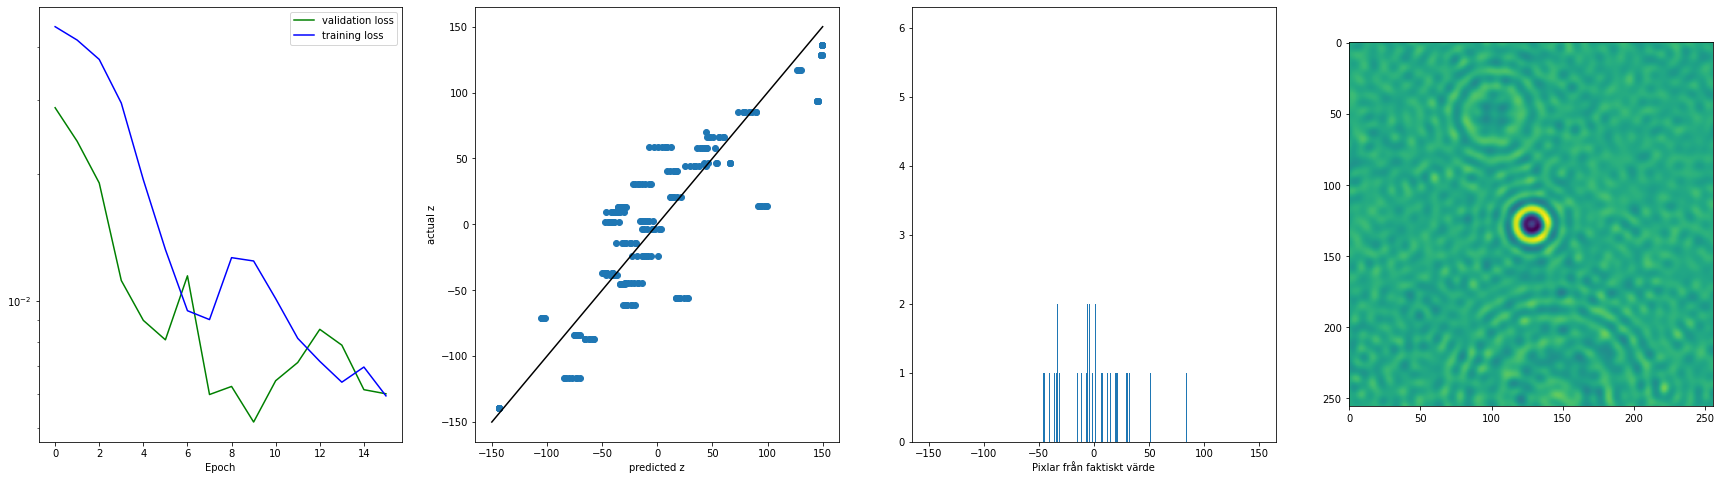

3 st kernel_size 3x3, med maxpooling 4x4
{'sigma': 30.576, 'mu': 13.045}


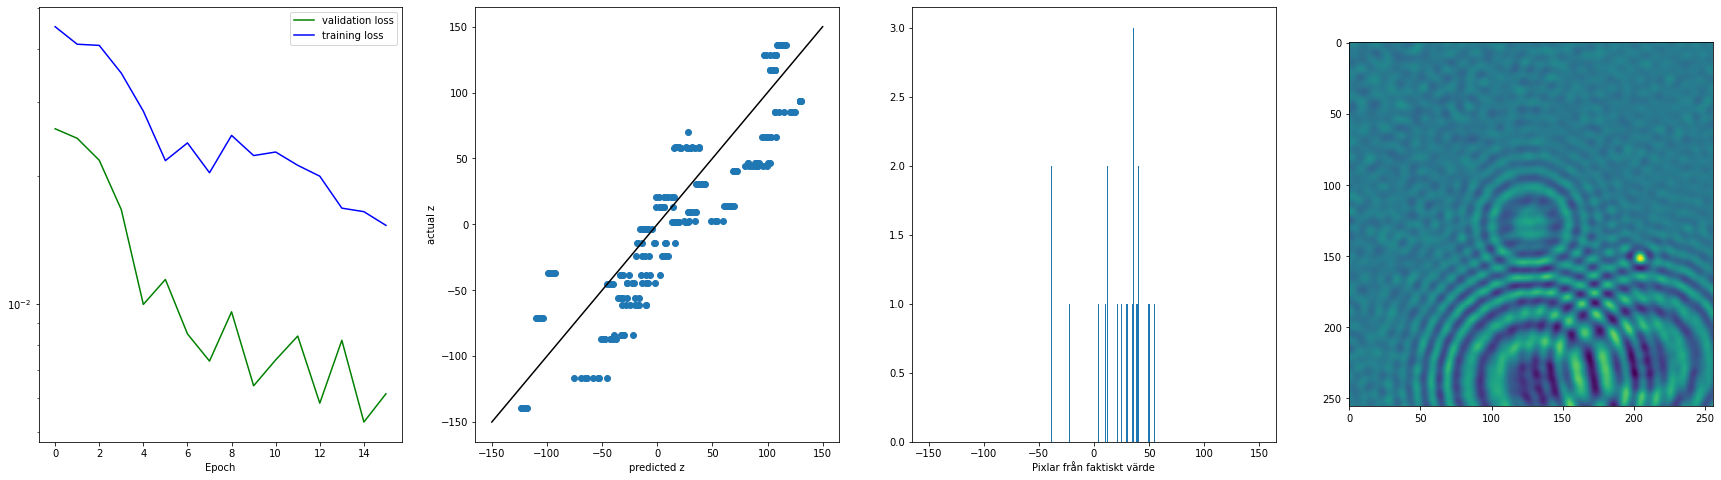

3 st kernel_size 3x3, med maxpooling 2x2
{'sigma': 38.674, 'mu': 3.624}


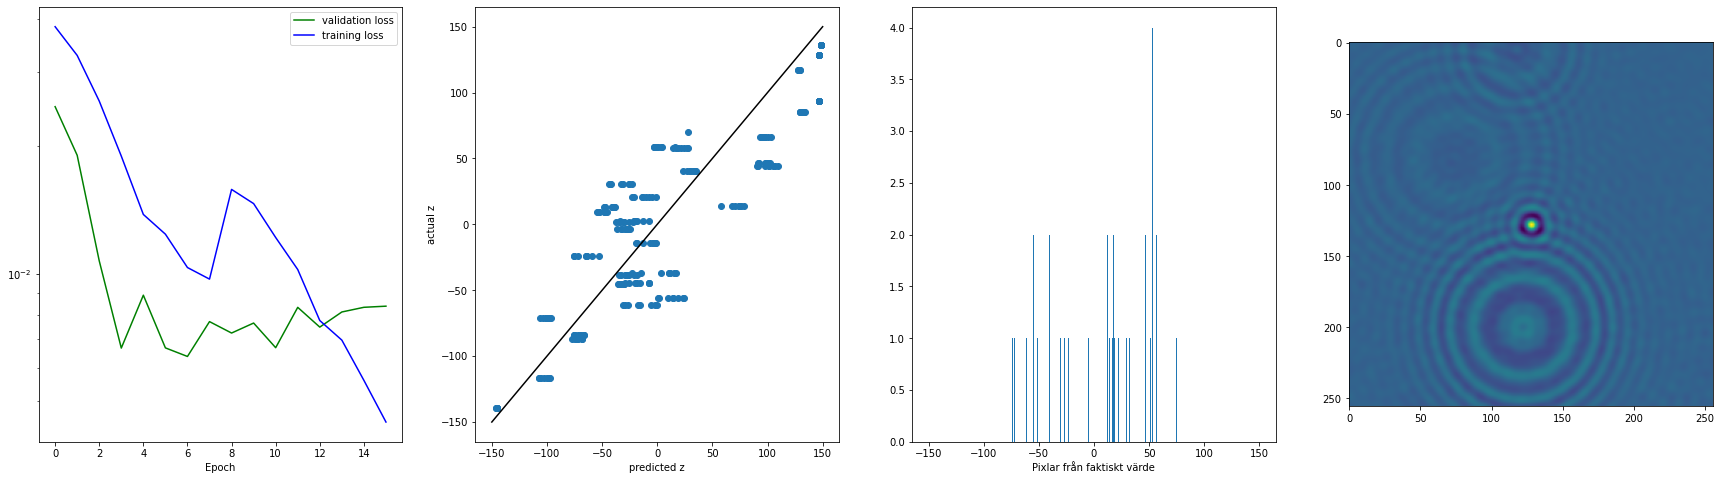

3 st kernel_size 16, 32, 16 och stride 3, 2 ingen maxpooling
{'sigma': 25.531, 'mu': 2.182}


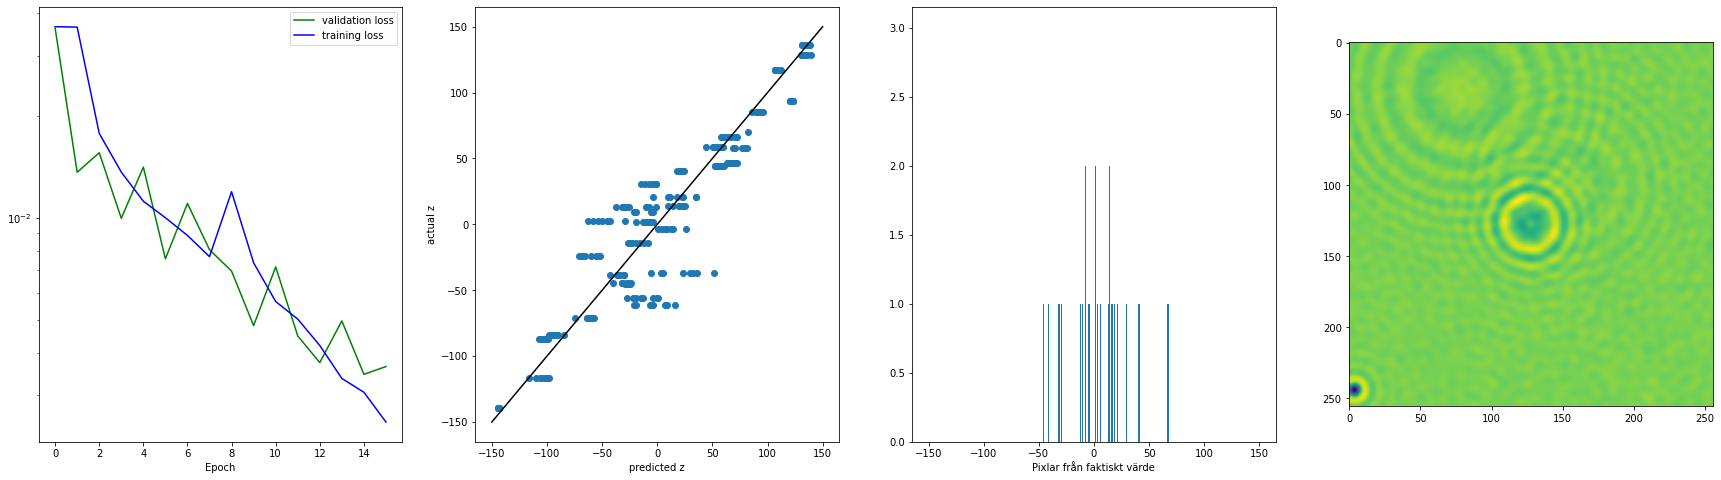

3 st kernel_size 3x3, med maxpooling 4x4
{'sigma': 30.514, 'mu': 2.274}


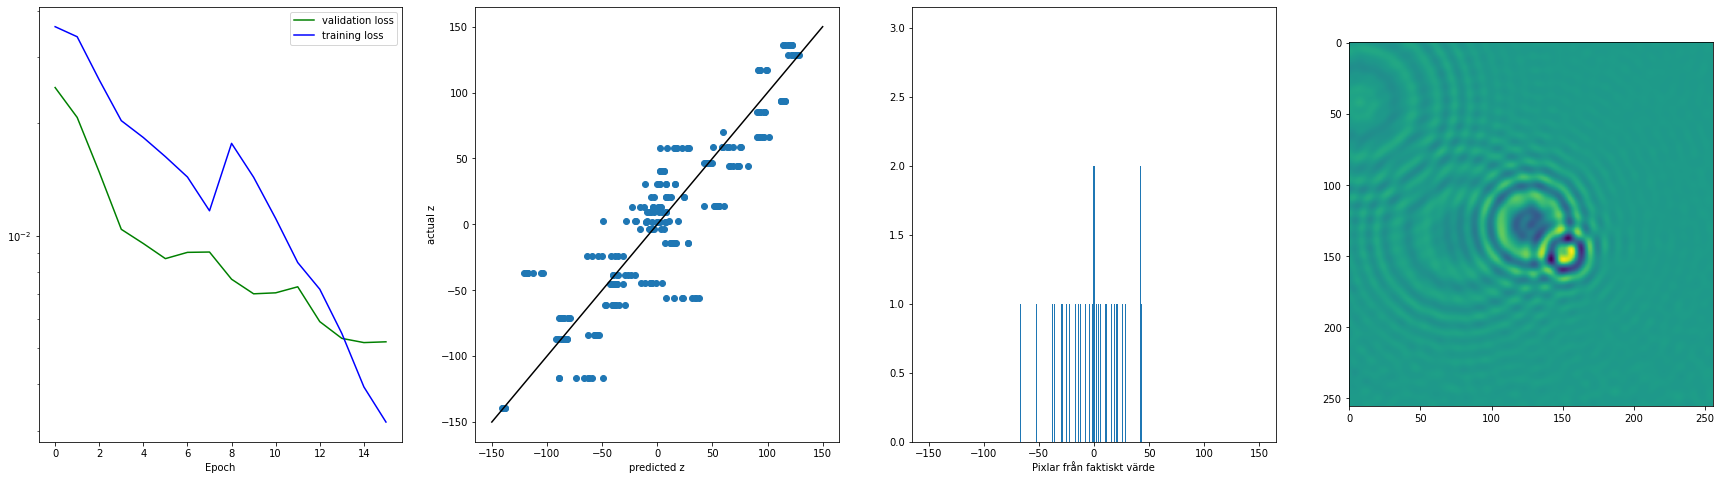

3 st kernel_size 3x3, med maxpooling 2x2
{'sigma': 30.17, 'mu': 4.671}


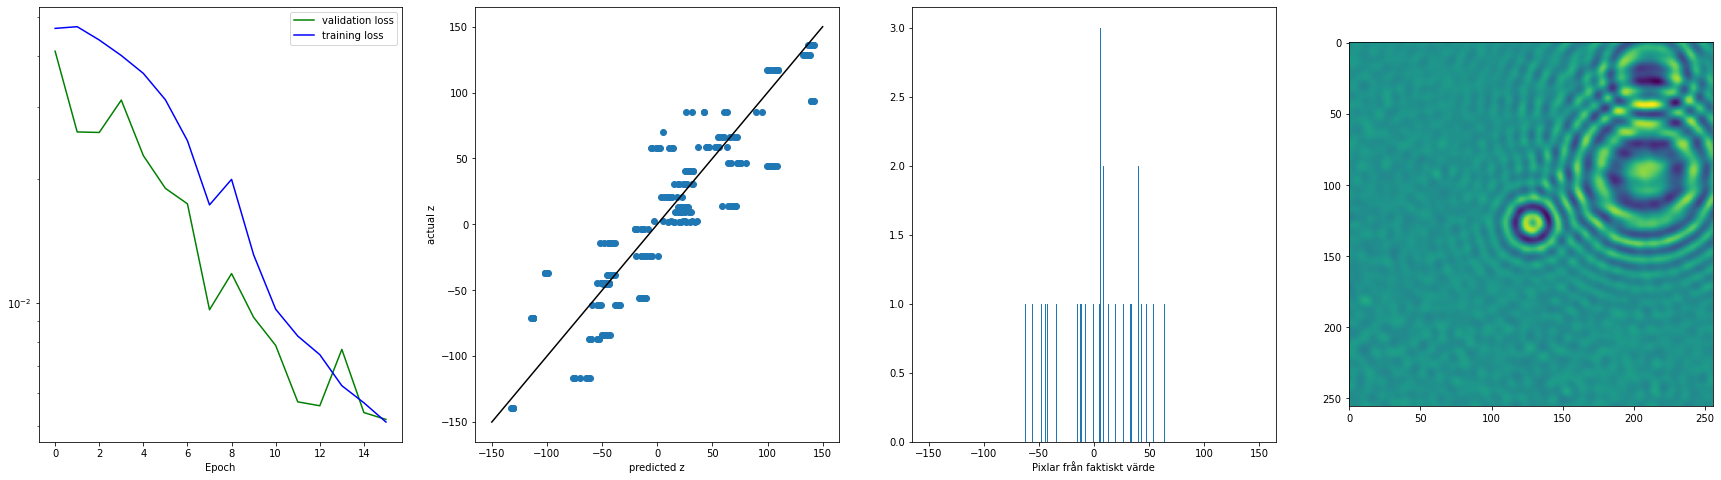

3 st kernel_size 3x3, med maxpooling 4x4
{'sigma': 31.275, 'mu': -4.431}


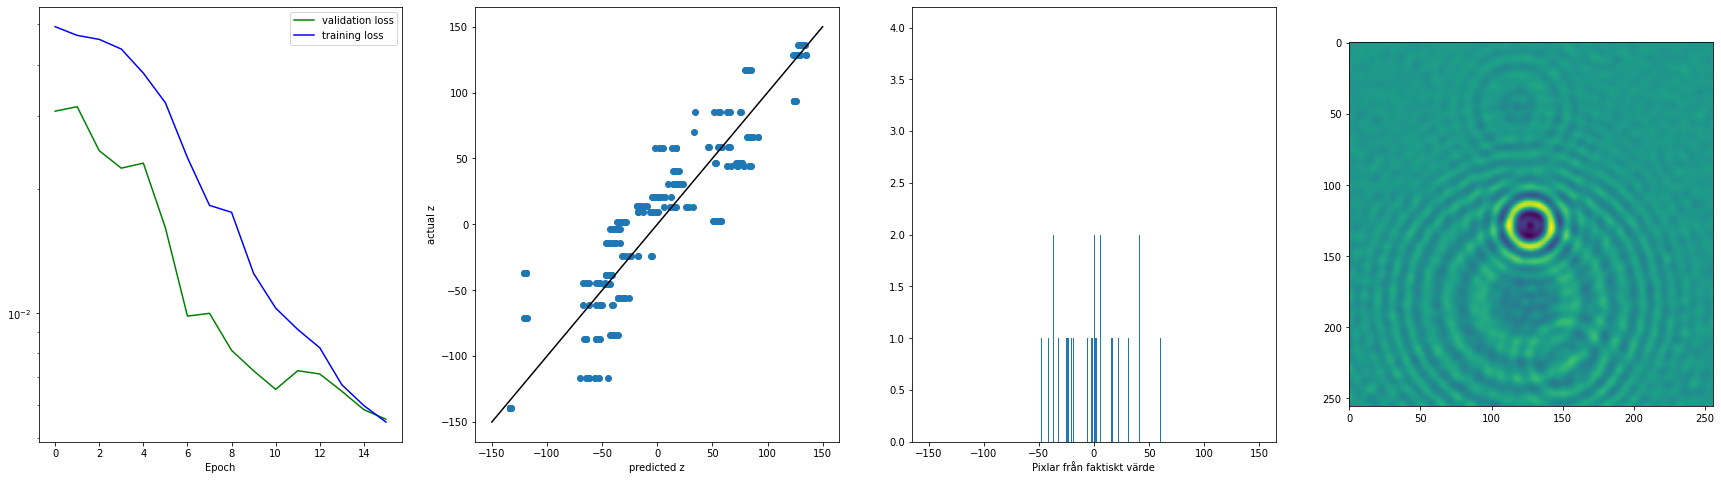

3 st kernel_size 16, 32, 16 och stride 3, 2 ingen maxpooling
{'sigma': 23.469, 'mu': -9.989}


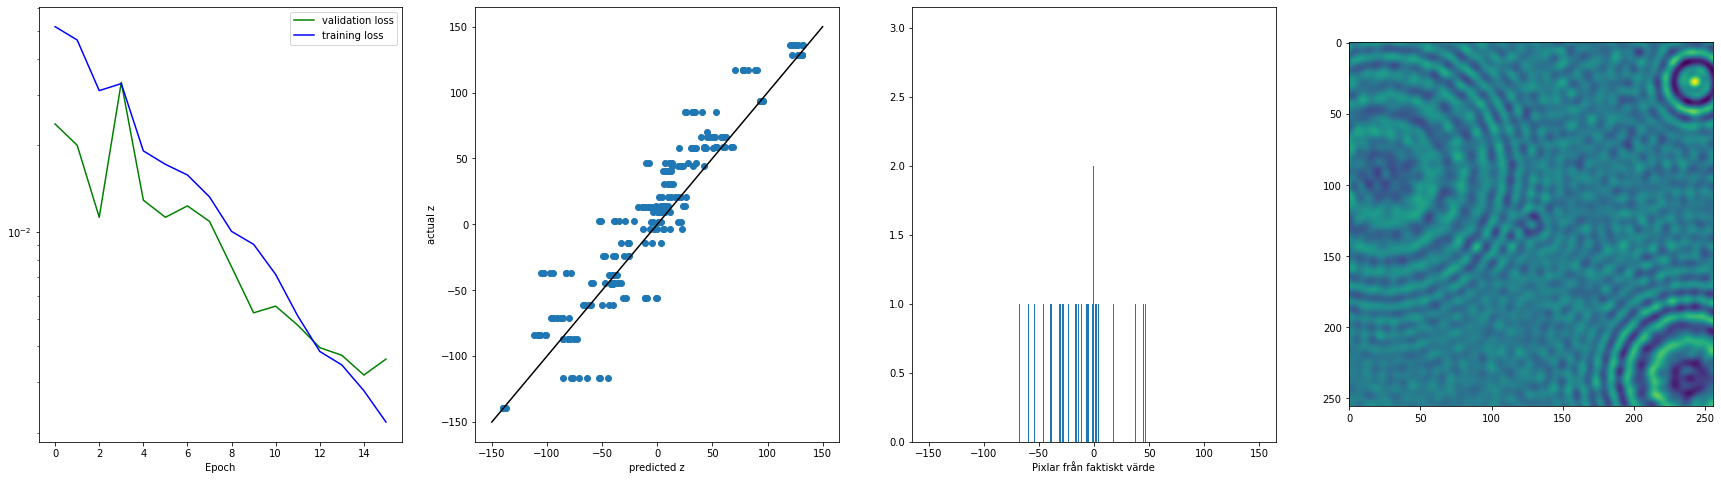

welcome!


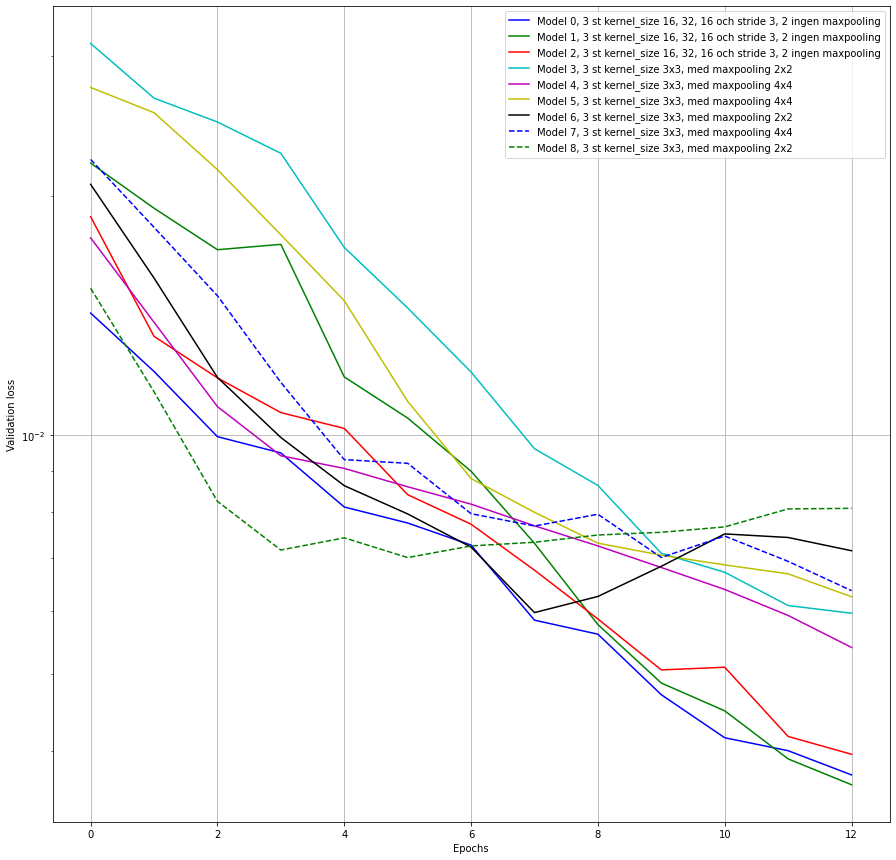

Generating 768 / 512 samples before starting training
3 st kernel_size 16, 32, 16 och stride 3, 2 ingen maxpooling
{'sigma': 21.724, 'mu': -3.722}


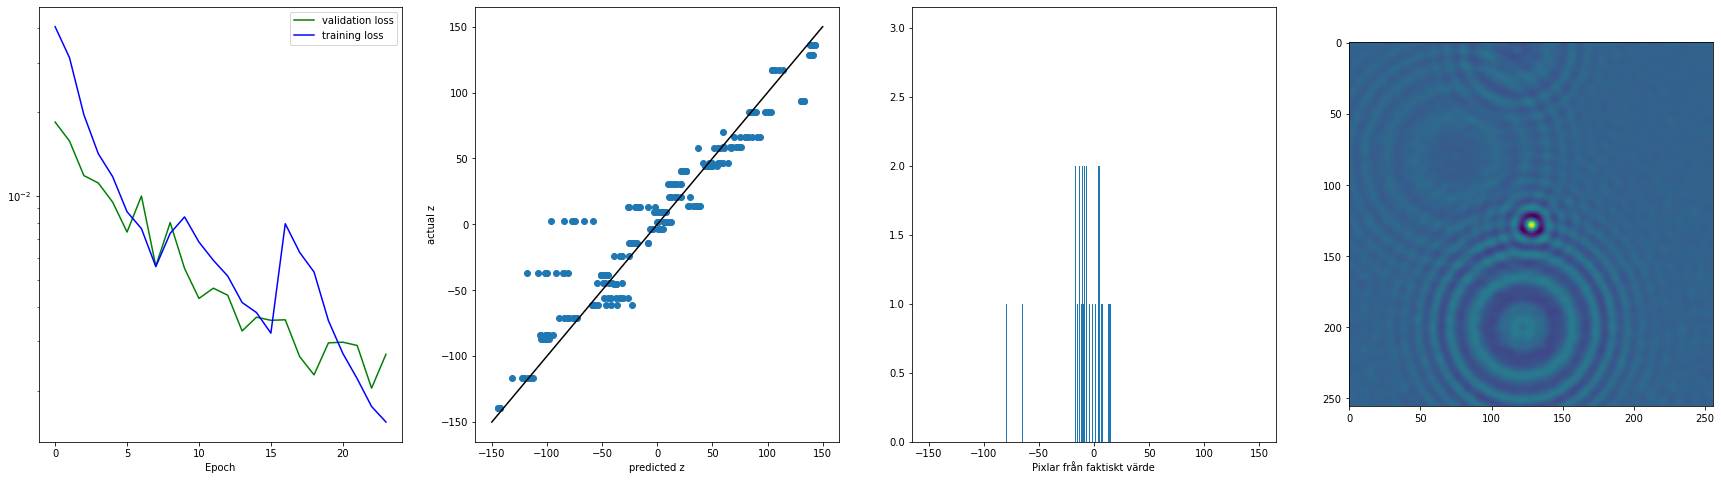

3 st kernel_size 16, 32, 16 och stride 3, 2 ingen maxpooling
{'sigma': 20.507, 'mu': -3.437}


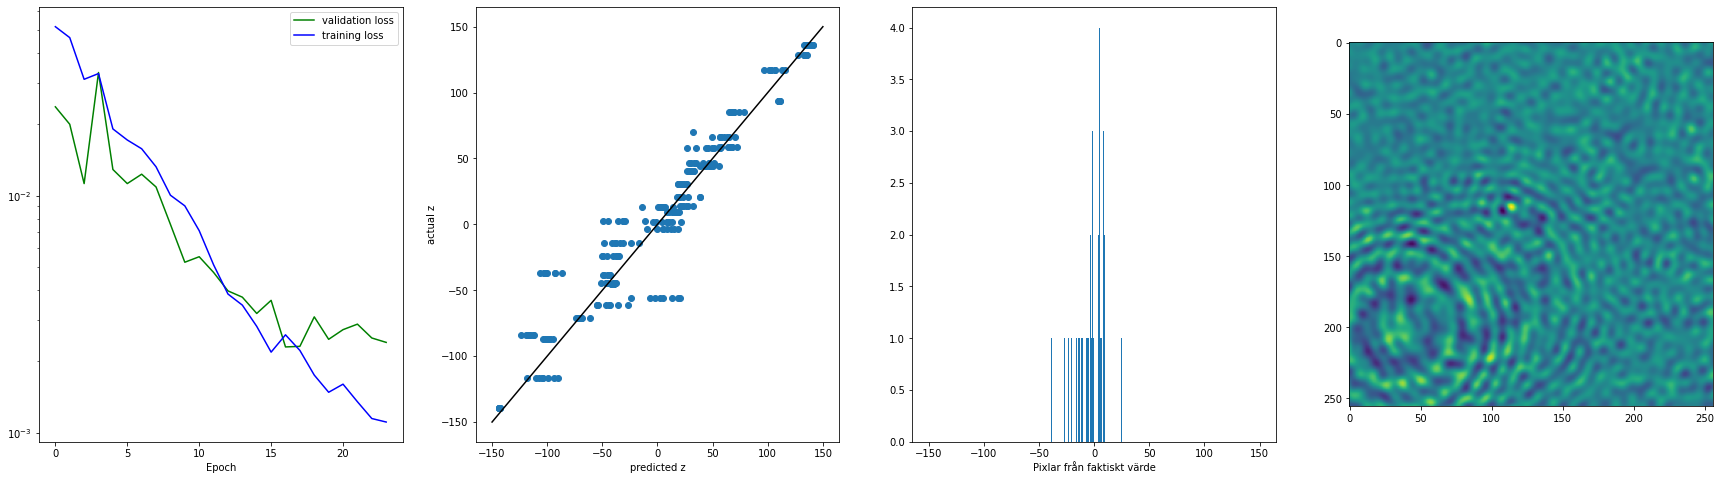

3 st kernel_size 16, 32, 16 och stride 3, 2 ingen maxpooling
{'sigma': 18.392, 'mu': -2.553}


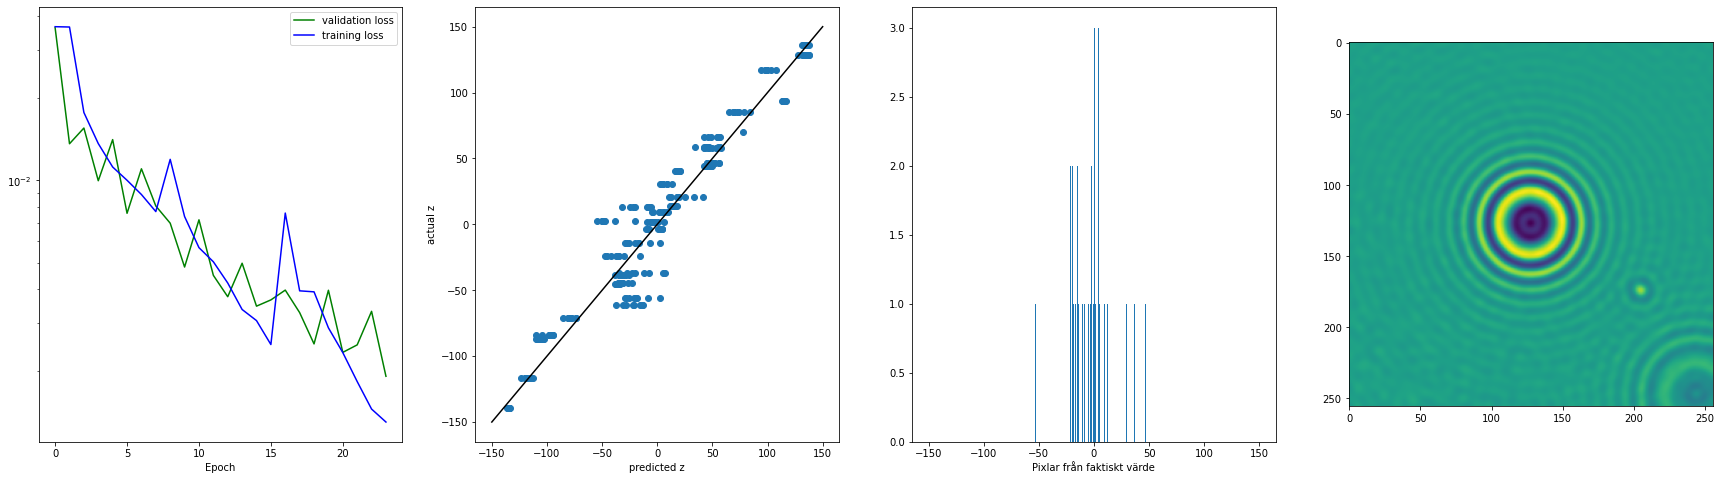

3 st kernel_size 3x3, med maxpooling 2x2
{'sigma': 29.193, 'mu': 13.21}


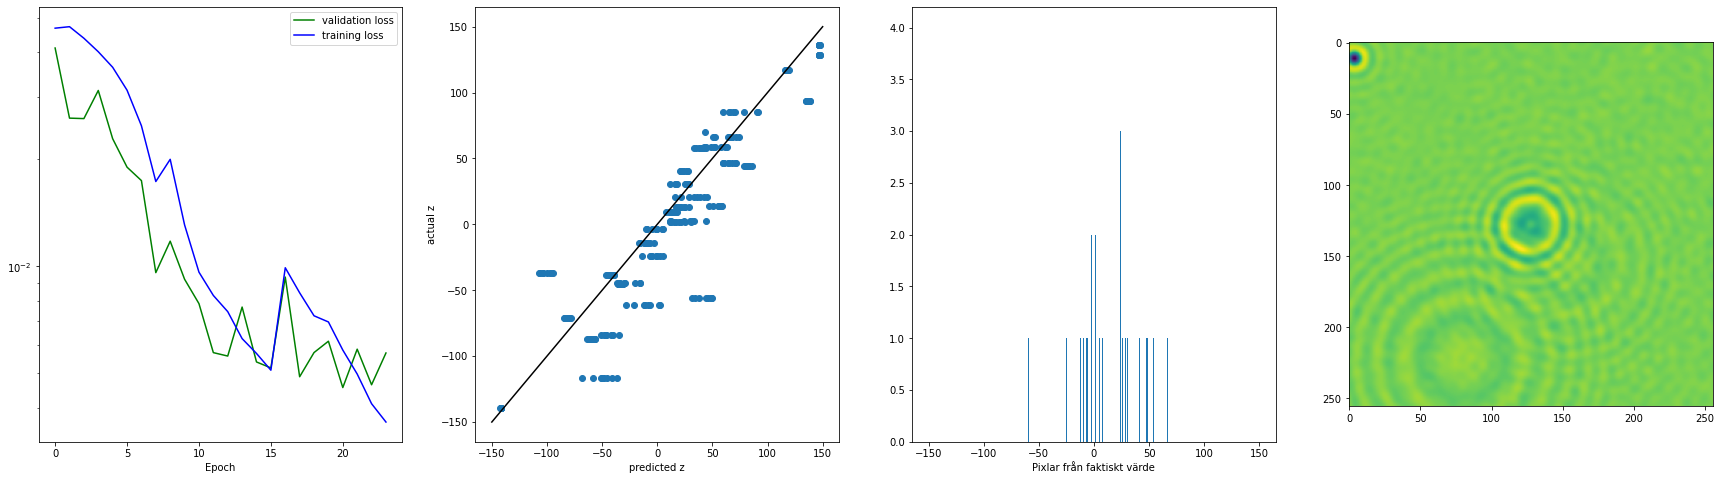

3 st kernel_size 3x3, med maxpooling 4x4
{'sigma': 22.659, 'mu': 8.945}


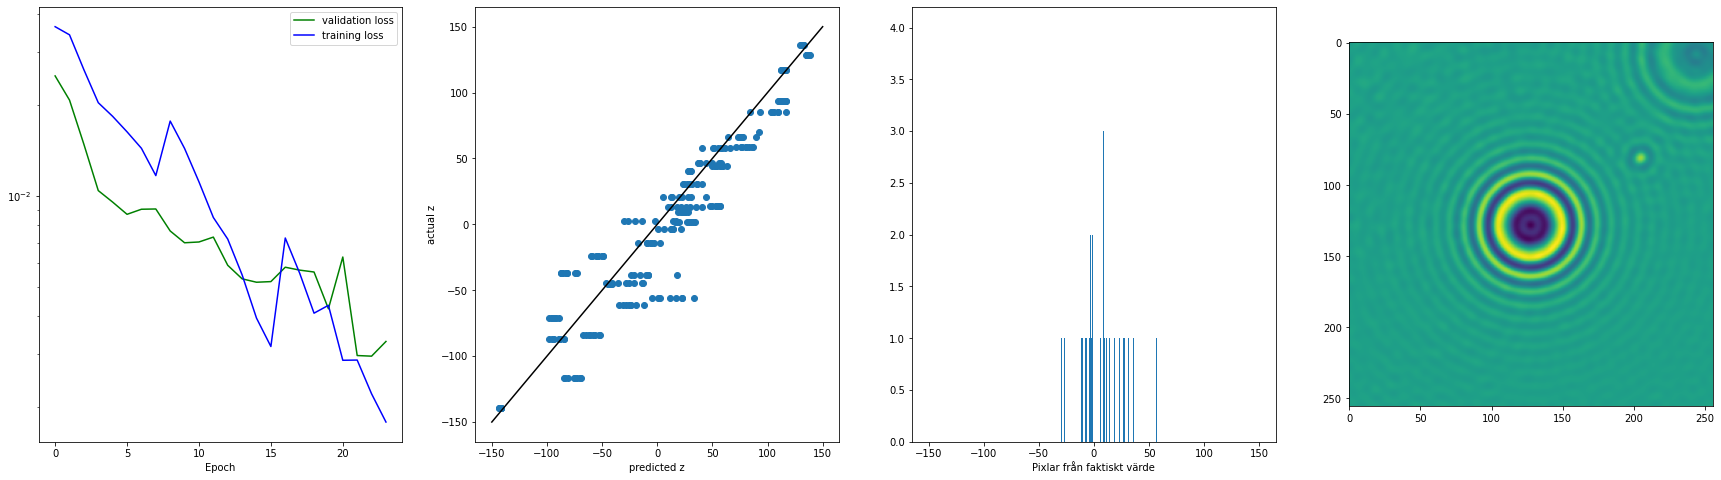

3 st kernel_size 3x3, med maxpooling 4x4
{'sigma': 27.379, 'mu': 8.805}


In [ ]:
"""Training all the models"""
validation_set_size = 128*2
batch_size = 128*2
min_number_models = 10

validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size=batch_size*2,
    max_data_size=batch_size*3,
    batch_size=batch_size,
)

for _ in range(150):
    with generator:
        for i, model in enumerate(models_to_train):
            h = model.fit(
                generator,
                validation_data=(
                    np.array(validation_set), 
                    np.array(validation_labels)
                ),
                epochs=8,
                verbose=0,
            )
            print(model.specs)
            save_progress(h, validation_set, validation_labels, model, plot=True)
        models_to_train.sort(key=lambda x: x.totalhistory["val_loss"][-1])     #Sort the models using validation loss as key.
        #if len(models) > min_number_models:                           #Delete the worst performing model if we have more than the minimum number.
        #    models = models[:-1]
        plot_together(models_to_train)

In [ ]:
import keras

def visualize_feature_maps(model, image_of_particle, SUBPLOT_SIZE=6, SUBPLOT_WIDTH=8):
    """
        # Parameters:
        model: The keras model whose featuremaps are to be visualized.
        image_of_particles: The image that should be visualized.
        SUBPLOT_SIZE: The size of each individual subplot.
        SUBPLOT_WIDTH: The number of subplots to lign up horizontally. Prefferably a multiple of two.
    """
    # Plotting the two input channels (Im() and Re())
    input_fig, ax = plt.subplots(1, 2)

    ax[0].imshow(image_of_particle[:, :, 0], cmap='gray')
    ax[0].set_title("Real (?) part")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(image_of_particle[:, :, 1], cmap='gray')
    ax[1].set_title("Im (?) part")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.show()

    # Plotting all outputs from convolutional layer, each layer is given its own figure
    IMAGE_SIZE = image_of_particle.shape[0]
    img = image_of_particle.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 2) # Reshape needed for model prediction input

    for layer in model.layers:
        if 'conv' not in layer.name: # Ignoring non-convolutional layers
            continue
        
        NUMBER_OF_OUTPUTS = layer.output.shape[3] # Total number of subplots
        SUBPLOT_HEIGHT = NUMBER_OF_OUTPUTS // SUBPLOT_WIDTH # Number of rows needed

        # Create a submodel equal to the original model but cut off at the current layer.
        submodel = keras.Model(inputs=model.inputs, outputs=layer.output)

        # Generate prediction outputs for the submodel
        feature_maps = submodel.predict(img)

        # Plotting all the outputs in a square figure

        output_number = 0
        fig, ax = plt.subplots(SUBPLOT_HEIGHT, SUBPLOT_WIDTH, figsize=(SUBPLOT_WIDTH * SUBPLOT_SIZE, SUBPLOT_HEIGHT * SUBPLOT_SIZE))
        fig.suptitle("Output of layer: " + layer.name)
        ax = ax.flatten()

        for output_number, axis in zip(range(len(ax)), ax):
            axis.imshow(feature_maps[0, :, :, output_number], cmap='gray')
            ax[output_number].set_xticks([])
            ax[output_number].set_yticks([])
                
        plt.show()

model=models[0]
image_of_particle=validation_set[0]
visualize_feature_maps(model, image_of_particle, SUBPLOT_SIZE=6, SUBPLOT_WIDTH=8)